# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [7]:
# ploting
%matplotlib inline
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

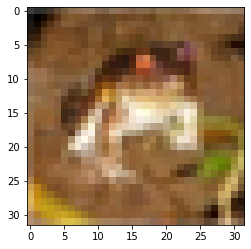

In [8]:
# data loading
cifar_sample = np.load('resources/cifar_sample.npy')
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1,2,0)) 

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="./resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [9]:
def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape 
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    out_height = int((img_height - filter_size + 2* padding)/stride +1)
    out_width = int((img_width - filter_size + 2* padding)/stride +1)
    out_channels = n_filters
    
    # your code here
    
    #Zero padding
    pad = torch.zeros([img_channels,img_height+2*padding,img_width + 2*padding])
    i=0
    j=0
    for c in range(img_channels):
        for h in range(padding,img_height+padding):
            for w in range(padding, img_width+padding):
                pad[c,h,w]=image[c,i,j]
                j+=1
            i+=1
            j=0
        i=0
    
    
    #convolution
    cha,height,width=pad.shape
    conv = torch.zeros([out_channels, out_height, out_width],dtype=torch.float32)
    i=0
    j=0
    for c in range(out_channels):
        for h in range(0,height,stride):
            if(h+filter_size>height):
                break
            for w in range(0,width,stride):
                if(w+filter_size > width):
                    break
                conv[c,i,j]=torch.sum(pad[:,h:h+filter_size,w:w+filter_size]*filters[c,:,:,:]) + bias[c]
                j+=1
            i+=1
            j=0
        i=0
            
        
    return conv

In [10]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [(torch.randn((2,3,3,3)), torch.randn((2))),
           (torch.randn((2,3,5,5)), torch.randn((2))),
           (torch.randn((5,3,1,1)), torch.randn((5)))]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [11]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = int((img_height + 2*padding - kernel_size)/stride + 1) 
    out_width = int((img_width + 2*padding - kernel_size)/stride + 1) 
    out_channels = img_channels

    # your code here
    
    
    #zero padding
    pad = torch.zeros([img_channels,img_height+2*padding,img_width + 2*padding])
    i=0
    j=0
    for c in range(img_channels):
        for h in range(padding,img_height+padding):
            for w in range(padding, img_width+padding):
                pad[c,h,w]=image[c,i,j]
                j+=1
            i+=1
            j=0
        i=0
        
#     print(image[0,:,:])
#     print()
#     print()
#     print(pad[0,:,:])

    #max pooling
    cha,height,width=pad.shape
    out = torch.zeros([out_channels, out_height, out_width],dtype=torch.float32)
    i=0
    j=0
    for c in range(out_channels):
        for h in range(0,height,stride):
            if(h+kernel_size>height):
                break
            for w in range(0,width,stride):
                if(w+kernel_size > width):
                    break
                out[c,i,j]=torch.max(pad[c,h:h+kernel_size,w:w+kernel_size])
                j+=1
            i+=1
            j=0
        i=0
            

    return out

In [12]:
image = torch.tensor([[[2,3,1,14],[-2,-1,2,1],[-5,5,-5,5],[1,1,1,1]]])
out = max_pooling(image, kernel_size=2, stride=1, padding=1)
print(image)
print(out)

tensor([[[ 2,  3,  1, 14],
         [-2, -1,  2,  1],
         [-5,  5, -5,  5],
         [ 1,  1,  1,  1]]])
tensor([[[ 2.,  3.,  3., 14., 14.],
         [ 2.,  3.,  3., 14., 14.],
         [ 0.,  5.,  5.,  5.,  5.],
         [ 1.,  5.,  5.,  5.,  5.],
         [ 1.,  1.,  1.,  1.,  1.]]])


In [13]:
# Max Pooling Test
from itertools import product

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride)
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)